In [1]:
# %matplotlib notebook
# import matplotlib.pyplot as plt

In [1]:
import numpy as np
import scipy as sc
import numpy.linalg as npl
from numpy.linalg import norm
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase
from tqdm import tqdm_notebook as tqdm_cs

In [2]:
%matplotlib notebook
import numpy as np
import pylab as plt

import tabulate
from ipywidgets import Label, Button, Output, FloatSlider, HBox, VBox, Layout, HTML, Accordion, interactive, interactive_output
from widget_code_input import WidgetCodeInput
from IPython.display import display

In [3]:
from tools import manipulation_hist,manipulation_LJ_force,manipulation_Harmonique_force,manipulation_LJ,get_numerical_force,manipulation_Harmonique
from tools import visualiser_trajectoire,faire_une_chaine_circulaire,faire_une_chaine_lineaire
from appmode_functions import get_recompute

# Developper les fonctions pour modeliser une chaine de polymere

<img src="figures/r2_r1-01.png" width="250" height="250" />

## Potentiel harmonique

Le potentiel harmonique est donné par:

$V_{har}\,\left(d\right) = k \,\left(d-r_m\right)^2,$

où $d$ est la longueur du ressort, $r_m$ est la longueur du ressort au repos et $k$ est la constante de raideur du ressort.
Si les extrémités du ressort sont données par les vecteurs $\vec{r_1} = \left(x_1,\, y_1,\,  z_1\right)$ et $\vec{r_2} = \left(x_2,\, y_2,\,  z_2\right)$ respectivement, alors $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$.


In [4]:
class SetUpHarmonicPotential(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Potentiel [e]")
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders
        r_m_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(r_m\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        k_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(k\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        self.sliders_dict = dict(r_m=r_m_widget,k=k_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],k=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Potentiel_Harmonique", 
            function_parameters="d, r_m, k",
            docstring="""
        Implémente l'énergie potentielle associée à un ressort

        :param d: distance [l]
        :param r_m: distance de repos du ressort [l]
        :param k: force du ressort [e/l] 

        :return: Valeur de l'énergie potentielle du ressort [e]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution")
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
        # self.plot = interactive_output(self.replot, self.sliders_dict)
    
    def display(self):
        display(self.code_widget)
        display(self.input_box,self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,k):
        ### Retourne la valeur du potentiel harmonique
        return k*( d - r_m)**2
    
    def replot(self, r_m, k):
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((r_m, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        r = np.linspace(-2, 6, num=100)
        self.the_plot.plot(r, self.reference_func(r,r_m,k))


        # plt.show()
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-0.5,4)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()


WidgetCodeInput(docstring="\n        Implémente l'énergie potentielle associée à un ressort\n\n        :param d: distance [l]\n        :param r_m: distance de repos du ressort [l]\n        :param k: force du ressort [e/l] \n\n        :return: Valeur de l'énergie potentielle du ressort [e]\n        ", function_body='# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution', function_name='Potentiel_Harmonique', function_parameters='d, r_m, k')

VBox(children=(FloatSlider(value=2.0, continuous_update=False, description='\\(r_m\\)', layout=Layout(min_width='350px', width='50%'), max=5.0, min=0.5, step=0.2, style=SliderStyle(description_width='initial')), FloatSlider(value=2.0, continuous_update=False, description='\\(k\\)', layout=Layout(min_width='350px', width='50%'), max=5.0, min=0.5, step=0.2, style=SliderStyle(description_width='initial'))))

<IPython.core.display.Javascript object>


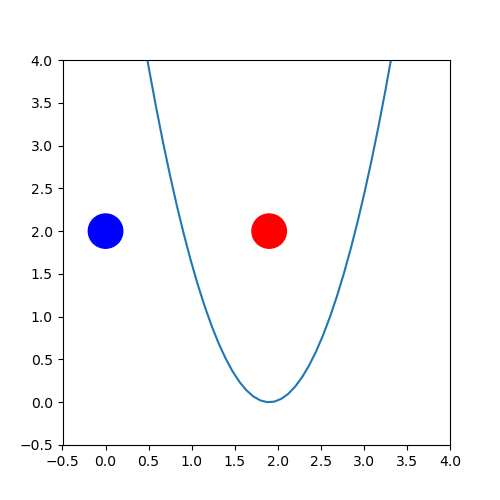

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voir le résultat)'})

In [5]:
setup_class = SetUpHarmonicPotential()

recompute = get_recompute(setup_class)

_ = recompute(None)

setup_class.display()